# **Titanic (random forest classifier)**
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/titanic_randomforest.ipynb
* kaggle: https://www.kaggle.com/c/titanic

In [1]:
import math
import json
import copy
import re
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

from IPython.display import JSON
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.1.5
numpy   version: 1.19.5
seaborn version: 0.11.1


### **utility functions**

In [4]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)

# data
Variable	Definition	Key
Survived	Survival	0 = No, 1 = Yes
Pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
Sex	Sex	
Age	Age in years	
SibSp	# of siblings / spouses aboard the Titanic	
Sibling = brother, sister, stepbrother, stepsister	
Spouse = husband, wife (mistresses and fiancés were ignored)	
Parch	# of parents / children aboard the Titanic	
Parent = mother, father	
Child = daughter, son, stepdaughter, stepson	
Some children travelled only with a nanny, therefore parch=0 for them.	
Ticket	Ticket number	
Fare	Passenger fare	
Cabin	Cabin number	
Embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
231,232,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
479,480,1,3,"Hirvonen, Miss. Hildur E",female,2.0,0,1,3101298,12.2875,NaN,S
402,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S
465,466,0,3,"Goncalves, Mr. Manuel Estanslas",male,38.0,0,0,SOTON/O.Q. 3101306,7.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df['Age']=df['Age'].fillna(df['Age'].median())

In [9]:
df['Sex']=df['Sex'].map({'female': 0, 'male': 1})

In [10]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C


# model

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
# ignore Date columns (use month and year instead)
feature_cols=[
    'Pclass', 
    'Sex', 
    'Age', 
    'SibSp',
    'Parch'
]
target_col='Survived'
X=df[feature_cols]
y=df[target_col]

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=1,
                                                    stratify=y)

In [15]:
# clf=LogisticRegression()
clf = RandomForestClassifier()

In [16]:
params={
    'bootstrap': True,
    'n_estimators': 5, # weak learners
    'max_depth': 5, # decision-tree levels
    'random_state': 7
}
clf = RandomForestClassifier(**params)

In [17]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [18]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [19]:
clf.score(X_train, y_train)

0.841091492776886

In [20]:
clf.score(X_test, y_test)

0.8208955223880597

In [21]:
clf.predict(X_test[:5])

array([0, 0, 0, 1, 0])

In [22]:
clf.predict_proba(X_test[:5])

array([[0.83990829, 0.16009171],
       [0.85957844, 0.14042156],
       [0.87526471, 0.12473529],
       [0.46242299, 0.53757701],
       [0.68928396, 0.31071604]])

# **confusion matrix**
$$
\begin{bmatrix}
C_{0,0} &amp; C_{0,1} \\
C_{1,0} &amp; C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&amp;fp \\
fn&amp;tp
\end{bmatrix}
$$
predicted false	predicted true
actual false	tn	fp
actual true	fn	tp


In [23]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

array([[153,  12],
       [ 36,  67]])

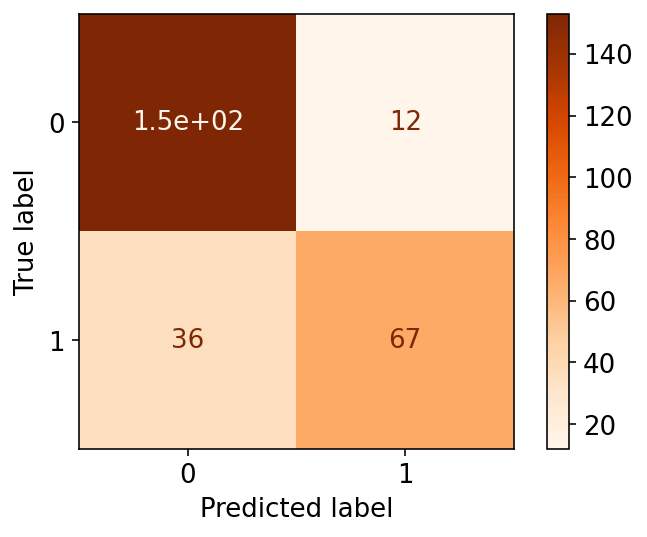

In [24]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges');


In [25]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       384
           1       0.88      0.67      0.76       239

    accuracy                           0.84       623
   macro avg       0.85      0.81      0.82       623
weighted avg       0.85      0.84      0.84       623



In [26]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       165
           1       0.85      0.65      0.74       103

    accuracy                           0.82       268
   macro avg       0.83      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



# cross validate score

In [27]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=sss, n_jobs=-1)
print(scores)
print(f'mean scores = {scores.mean()}, sd={scores.std():.4f}')

[0.81343284 0.83955224 0.83955224 0.79104478 0.80597015]
mean scores = 0.817910447761194, sd=0.0191


In [28]:
# doc: https://scikit-learn.org/stable/modules/model_evaluation.html
clf_scorings=[
    'accuracy'
]
eval_scores={}
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for s in clf_scorings:
    eval_scores[s]=cross_val_score(clf, X, y, cv=sss, n_jobs=-1, scoring=s)
    print(f'{s:10}: {eval_scores[s]}, mean={eval_scores[s].mean():.4f}, std={eval_scores[s].std():.4f}')

accuracy  : [0.81343284 0.83955224 0.83955224 0.79104478 0.80597015], mean=0.8179, std=0.0191


## **feature importances**

In [29]:
clf.feature_importances_

array([0.23971747, 0.4699344 , 0.17836832, 0.0794968 , 0.03248301])

In [30]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')

In [31]:
feature_importances=pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

Sex       0.469934
Pclass    0.239717
Age       0.178368
SibSp     0.079497
Parch     0.032483
dtype: float64

In [32]:
feature_importances.sum()

1.0000000000000002

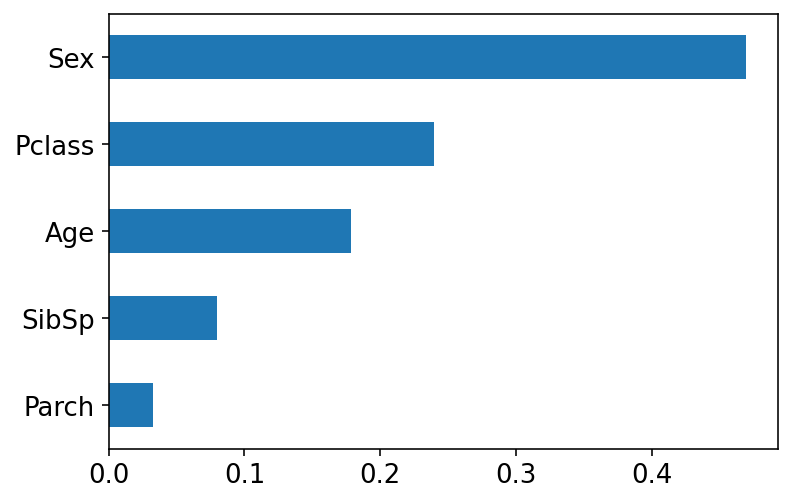

In [33]:
feature_importances.sort_values(ascending=True).plot(kind='barh');

In [34]:
pd.DataFrame(feature_importances).style.background_gradient(cmap="Oranges")

,0
Sex,0.469934
Pclass,0.239717
Age,0.178368
SibSp,0.079497
Parch,0.032483


	0
Sex	0.469934

Pclass	0.239717

Age	0.178368

SibSp	0.079497

Parch	0.032483

# Explore decision trees
install graphviz on Windows

install graphviz: pip install -U graphviz
download graphviz: https://www2.graphviz.org/Packages/stable/windows/10/msbuild/Release/Win32/
extract and copy to: C:\Program Files (x86)\Graphviz\bin
add C:\Program Files (x86)\Graphviz\bin to PATH
verify after installation: dot -V
install graphviz on macOS

install graphviz: pip install -U graphviz
sudo chown -R $(whoami) /usr/local/lib/pkgconfig /usr/local/share/info
chmod u+w /usr/local/lib/pkgconfig /usr/local/share/info
install graphviz: brew install graphviz
verify after installation: dot -V

In [35]:
params={
    'bootstrap': False, # use all training data (150 * .7) = 105 rows
    'n_estimators': 3, # weak learners = 3 (decisiontreeclassifier)
    'max_depth': 2,
    'random_state': 13
}
clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [36]:
clf.__dict__

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'base_estimator_': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'classes_': array([0, 1]),
 'cr

In [37]:
estimators=clf.estimators_

In [38]:
len(estimators)

3

In [39]:
estimators[0]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1192722770, splitter='best')

In [40]:
type(estimators[0])

sklearn.tree._classes.DecisionTreeClassifier

In [41]:
clf.classes_

array([0, 1])

In [42]:
from sklearn.tree import export_graphviz
from graphviz import Digraph, Source

def view_tree(model, feature_names, tree_index=0, save_tree_img=False):
    estimators=model.estimators_
    dot_graph=export_graphviz(estimators[tree_index], 
                feature_names = feature_names,
                class_names = ['dead', 'survived'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    g=Source(dot_graph)    
    if save_tree_img:
        g.render(f'tree{tree_index}', format='png', view=False, cleanup=True)
    return g

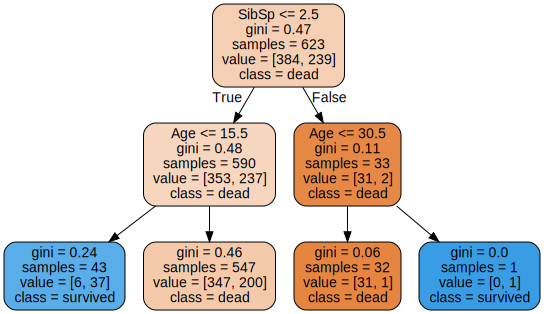

In [44]:
view_tree(clf, X.columns, 0, False)

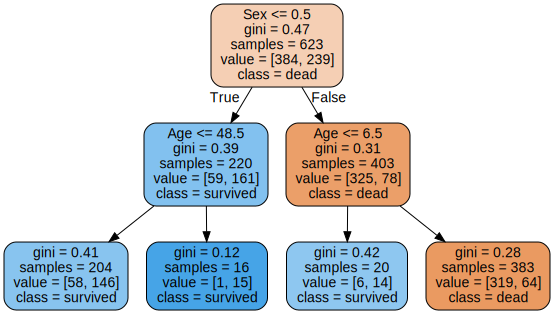

In [45]:
view_tree(clf, X.columns, 2, False)

## **interactive tree visualizer (simple)**

In [46]:
max_num_trees=len(clf.estimators_)
w_tree_index=widgets.BoundedIntText(
    value=0,
    min=0,
    max=max_num_trees-1,
    step=1,
    continuous_update=True,
)
@interact
def plot_tree(tree_index=w_tree_index, save_tree_img=[False, True]):
    return view_tree(clf, X.columns, tree_index, save_tree_img)

interactive(children=(BoundedIntText(value=0, continuous_update=True, description='tree_index', max=2), Dropdo…

## **interactive tree visualizer (with max_depth, bootstrap, n_estimators)**

In [47]:
max_num_trees=len(clf.estimators_)
w_tree_index=widgets.BoundedIntText(
    value=0,
    min=0,
    max=max_num_trees-1,
    step=1,
    continuous_update=True,
)
w_max_depth=widgets.BoundedIntText(
    value=2,
    min=2,
    max=10,
    step=1,
    continuous_update=True,
)
w_case_index=widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(X)-1,
    step=1,
    continuous_update=True,
)
w_n_estimators=widgets.BoundedIntText(
    value=3,
    min=1,
    max=50,
    step=1,
    continuous_update=True,
)
@interact
def plot_tree(case_index=w_case_index,
              tree_index=w_tree_index, 
              criteria=['gini', 'entropy'],
              max_depth=w_max_depth,
              n_estimators=w_n_estimators, 
              bootstrap=[False, True], save_tree_img=[False, True]):
    params={
    'criterion': criteria,
    'bootstrap': bootstrap,
    'n_estimators': n_estimators,
    'max_depth': max_depth
}
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    w_tree_index.max=w_n_estimators.value-1
    print(X.iloc[[case_index]])
#     print(clf.predict(X.iloc[[case_index]]))
    print(clf.predict_proba(X.iloc[[case_index]]))
    return view_tree(clf, X.columns, tree_index, save_tree_img)


interactive(children=(BoundedIntText(value=0, continuous_update=True, description='case_index', max=890), Boun…

Gini$$
gini=1-\sum _{i=1}^{J}{p_{i}}^{2}
$$

Entropy$$
Entropy=-\sum _{i=1}^{n}{{p_i}\log _{2}{p_i}}
$$



## **SAVE model**

In [48]:
import joblib
joblib_file = "rf_model.joblib"
joblib.dump(clf, joblib_file)
model=joblib.load(joblib_file)

In [49]:
model.predict(X_test)

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0])

# SHAP
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.
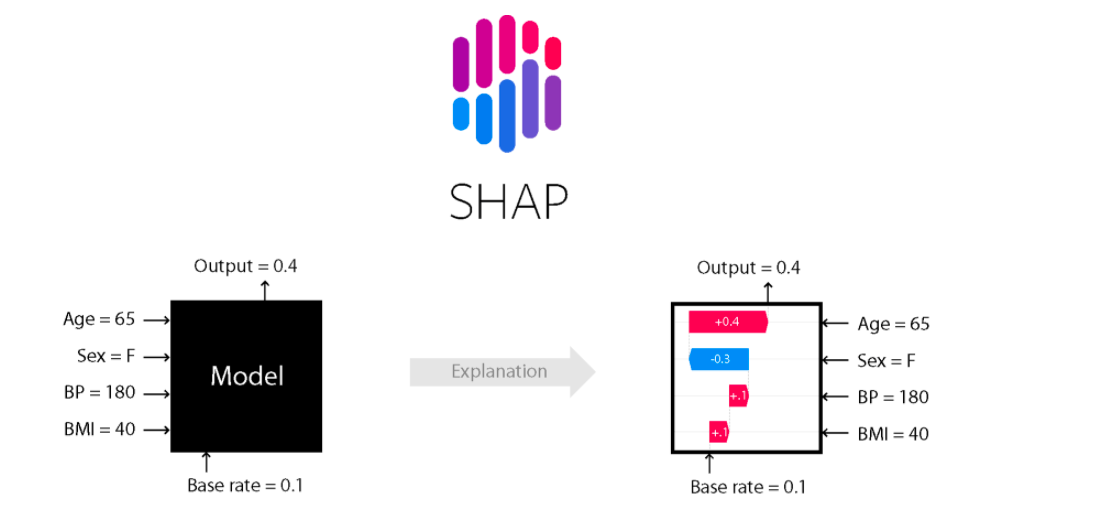


doc: https://shap.readthedocs.io/en/latest/
installation:
pip install shap or
conda install -c conda-forge shap

In [51]:
!pip install shap

     |████████████████████████████████| 358kB 22.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=73ac7608619a4e1ba96be7d29df08f0d59f558b2b9573def9e92d5b8b2f12805
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [52]:
import shap
print(f'shap version {shap.__version__}')

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap version 0.39.0


In [53]:
len(shap_values)

2

In [54]:
shap_values[1].shape

(891, 5)

In [55]:
shap_values[0][:5] # class = 0 (dead)

array([[ 0.01448445,  0.11439862,  0.02742964, -0.00596321,  0.        ],
       [-0.05067552, -0.260316  ,  0.0127504 ,  0.00258915,  0.        ],
       [ 0.05550176, -0.20955747,  0.02130277, -0.00596321,  0.        ],
       [-0.05067552, -0.260316  ,  0.0127504 ,  0.00258915,  0.        ],
       [ 0.01448445,  0.11439862,  0.01887727,  0.00258915,  0.        ]])

In [56]:
shap_values[1][:5] # class = 1 (survived)

array([[-0.01448445, -0.11439862, -0.02742964,  0.00596321,  0.        ],
       [ 0.05067552,  0.260316  , -0.0127504 , -0.00258915,  0.        ],
       [-0.05550176,  0.20955747, -0.02130277,  0.00596321,  0.        ],
       [ 0.05067552,  0.260316  , -0.0127504 , -0.00258915,  0.        ],
       [-0.01448445, -0.11439862, -0.01887727, -0.00258915,  0.        ]])

In [57]:
dshap=pd.DataFrame(shap_values[0], columns=feature_cols)
dshap

,Pclass,Sex,Age,SibSp,Parch
0,0.014484,0.114399,0.027430,-0.005963,0.0
1,-0.050676,-0.260316,0.012750,0.002589,0.0
2,0.055502,-0.209557,0.021303,-0.005963,0.0
3,-0.050676,-0.260316,0.012750,0.002589,0.0
4,0.014484,0.114399,0.018877,0.002589,0.0
...,...,...,...,...,...
886,-0.013225,0.142108,0.027430,-0.005963,0.0
887,-0.050676,-0.260316,0.021303,-0.005963,0.0
888,0.055502,-0.209557,0.021303,-0.005963,0.0
889,-0.013225,0.142108,0.027430,-0.005963,0.0


## **feature importances**

In [58]:
np.abs(dshap).mean().sort_values(ascending=False)

Sex       0.161580
Age       0.041153
Pclass    0.027694
SibSp     0.012590
Parch     0.000000
dtype: float64

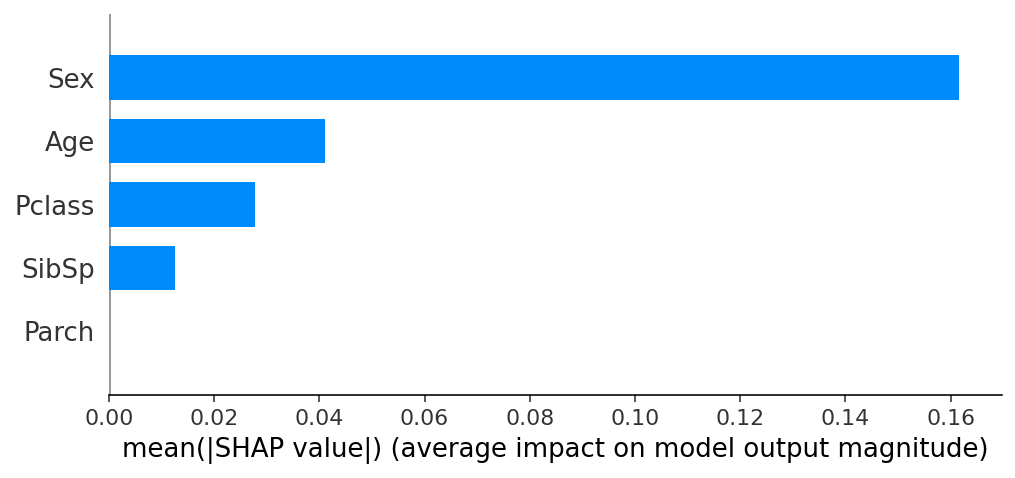

In [59]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

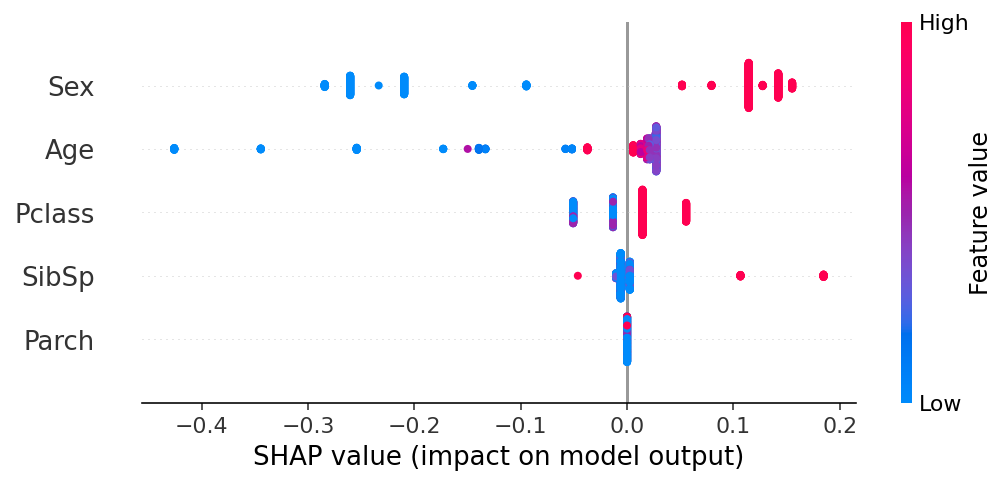

In [60]:
shap.summary_plot(shap_values[0], X)

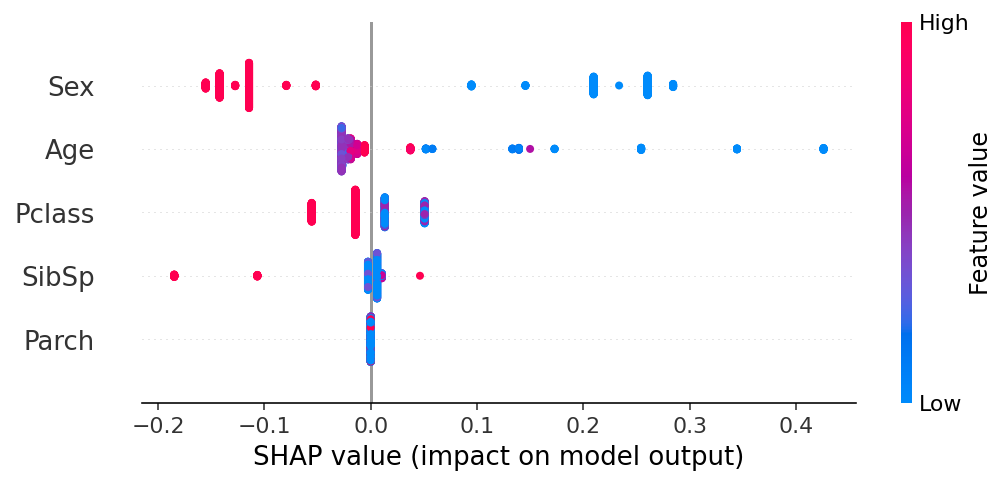

In [61]:
shap.summary_plot(shap_values[1], X)

## **dependence_plot¶**

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    int64  
 2   Age     891 non-null    float64
 3   SibSp   891 non-null    int64  
 4   Parch   891 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 34.9 KB


In [63]:
w_x1=widgets.ToggleButtons(
    options=X.columns.sort_values(),
    description='x1:',
    disabled=False,
)
w_x2=widgets.ToggleButtons(
    options=X.columns.sort_values(),
    description='x2:',
    disabled=False,
)
@interact
def interaction_plot(x1=w_x1, x2=w_x2, class_no=[0, 1]):
    try:
        shap.dependence_plot(x1, shap_values=shap_values[class_no], features=X, interaction_index=x2)  
    except:
        pass

interactive(children=(ToggleButtons(description='x1:', options=('Age', 'Parch', 'Pclass', 'Sex', 'SibSp'), val…

In [64]:
w_x1=widgets.ToggleButtons(
    options=X.columns.sort_values(),
    description='x1:',
    disabled=False,
)
w_x2=widgets.ToggleButtons(
    options=X.columns.sort_values(),
    description='x2:',
    disabled=False,
)
@interact
def interaction_plot(x1=w_x1, x2=w_x2, class_no=[0, 1]):
    try:
        shap.dependence_plot(x1, shap_values=shap_values[class_no], features=X, interaction_index=x2)  
    except:
        pass

interactive(children=(ToggleButtons(description='x1:', options=('Age', 'Parch', 'Pclass', 'Sex', 'SibSp'), val…

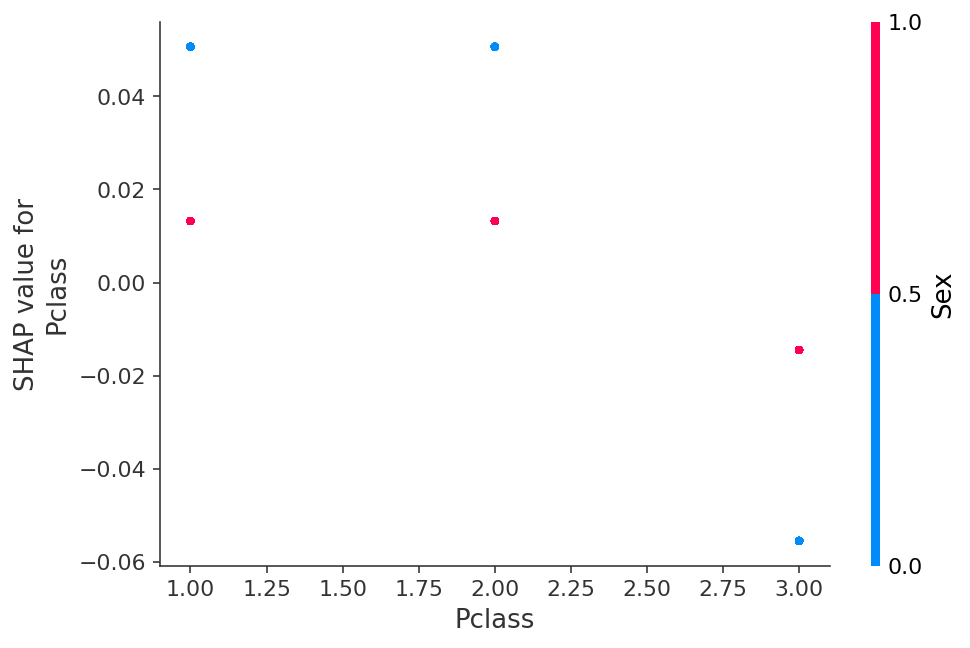

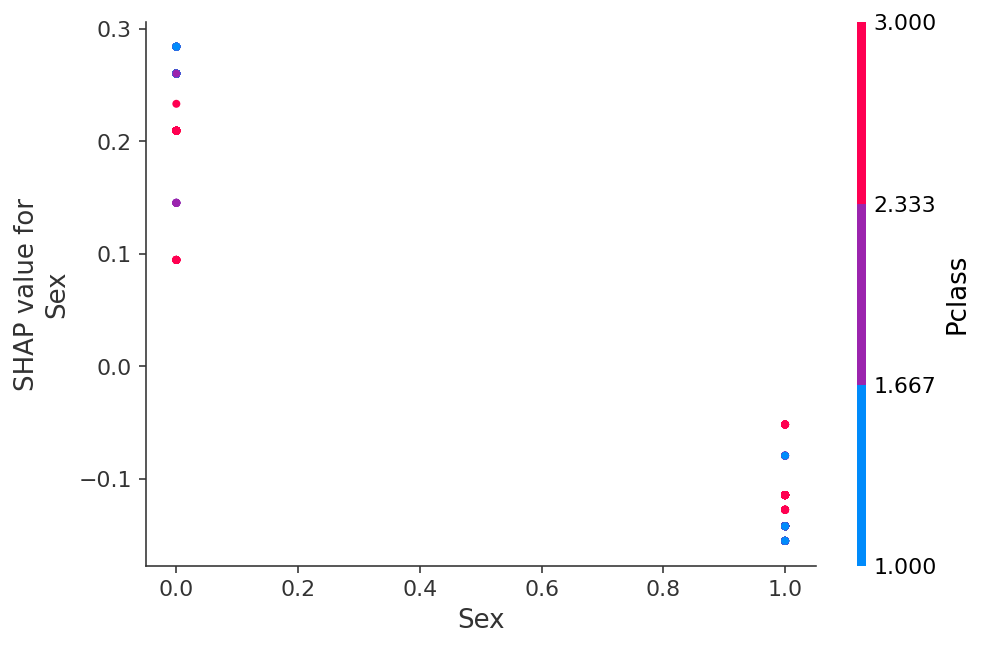

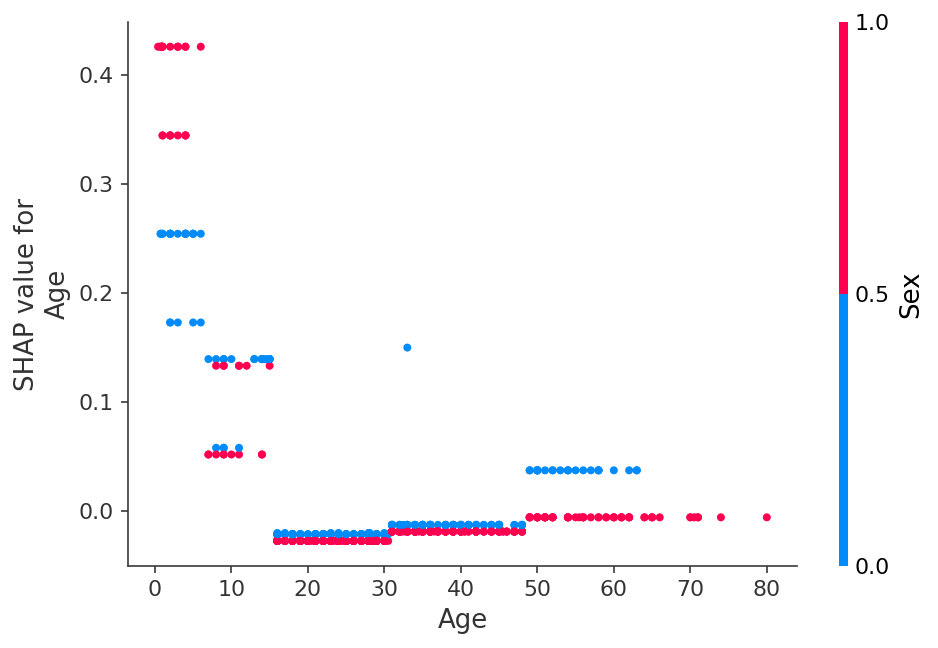

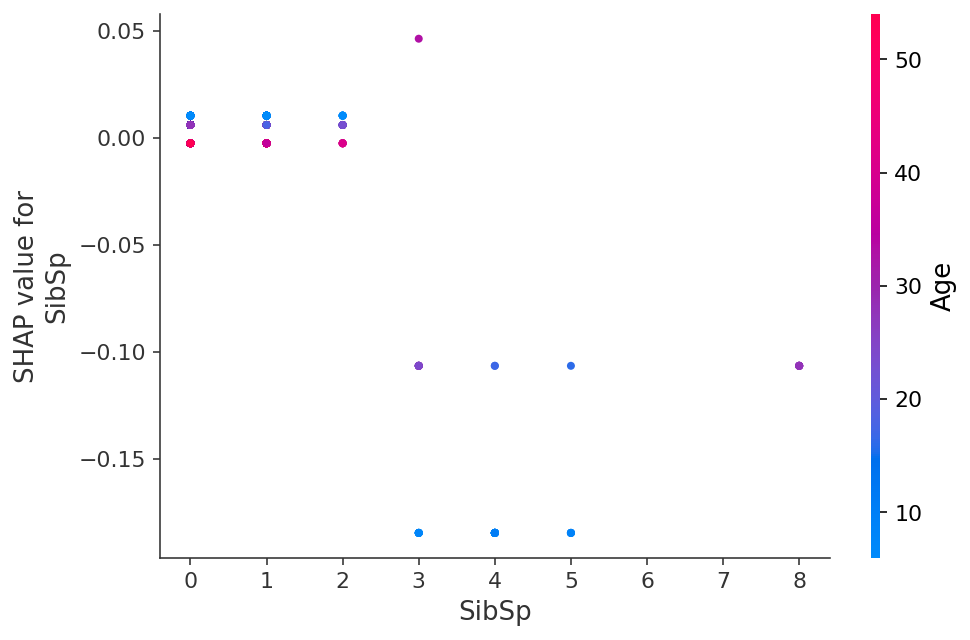

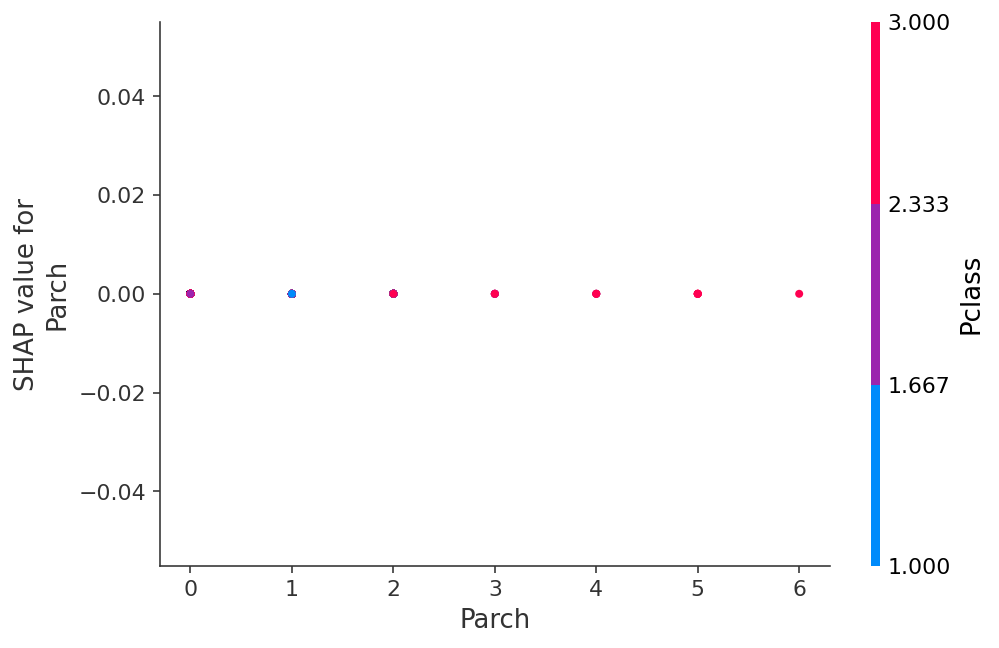

In [65]:
class_no=1
for c in feature_cols:
    try:
        shap.dependence_plot(c, shap_values=shap_values[class_no], features=X)    
    except:
        pass

## **interpret case(s)**

In [66]:
shap_values[0][:5]

array([[ 0.01448445,  0.11439862,  0.02742964, -0.00596321,  0.        ],
       [-0.05067552, -0.260316  ,  0.0127504 ,  0.00258915,  0.        ],
       [ 0.05550176, -0.20955747,  0.02130277, -0.00596321,  0.        ],
       [-0.05067552, -0.260316  ,  0.0127504 ,  0.00258915,  0.        ],
       [ 0.01448445,  0.11439862,  0.01887727,  0.00258915,  0.        ]])

In [67]:
X[:5]

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0
2,3,0,26.0,0,0
3,1,0,35.0,1,0
4,3,1,35.0,0,0


In [68]:
case_index=0
X.iloc[[case_index]]

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0


In [69]:
explainer.shap_values(X.iloc[[case_index]])[1]

array([[-0.01448445, -0.11439862, -0.02742964,  0.00596321,  0.        ]])

In [70]:
clf.predict_proba(X[:5])

array([[0.76672188, 0.23327812],
       [0.32072042, 0.67927958],
       [0.47765624, 0.52234376],
       [0.32072042, 0.67927958],
       [0.76672188, 0.23327812]])

In [71]:
clf.predict(X[:5])

array([0, 1, 1, 1, 0])

In [72]:
def individual_case_plot(explainer, X, case_index, class_no=1, link='identity', verbose=False):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
#     link='identity' # show value as log-odds
#     link='logit' # show value as prob
    shap_values = explainer.shap_values(X.iloc[[case_index]])[class_no]
    g=shap.force_plot(explainer.expected_value[class_no], shap_values=shap_values, features=X.iloc[case_index, :], link=link)
    if verbose:
        print(f'predict_proba = {clf.predict_proba(X.iloc[[case_index]])}')
        pprint(g.__dict__)
    return g

In [73]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='identity', verbose=True)
g

predict_proba = [[0.76672188 0.23327812]]
{'data': {'baseValue': 0.3836276083467094,
          'featureNames': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'],
          'features': {0: {'effect': -0.014484445463578688, 'value': 3.0},
                       1: {'effect': -0.11439861657281253, 'value': 1.0},
                       2: {'effect': -0.02742963801432898, 'value': 22.0},
                       3: {'effect': 0.005963214481467693, 'value': 1.0}},
          'link': 'identity',
          'outNames': ['f(x)'],
          'outValue': 0.23327812277745688,
          'plot_cmap': 'RdBu'}}


In [74]:
w_case_index=widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(X)-1,
    step=1,
    continuous_update=True,
)
class_no=1
@interact
def plot_case(case_index=w_case_index, class_no=[0, 1], verbose=[False, True]):
    g=individual_case_plot(explainer, X, case_index=case_index, class_no=class_no, 
                           link='identity', verbose=verbose)
    return g

interactive(children=(BoundedIntText(value=0, continuous_update=True, description='case_index', max=890), Drop…

In [ ]:
class_no=1
shap.force_plot(explainer.expected_value[class_no], shap_values[class_no][:], X[:])